In [75]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io,segmentation,future,color,data,feature,measure,morphology,filters,util,restoration
from scipy import ndimage
import matplotlib.patches as mpatches

# Image Segmentation 
Grouping of Pixels which form a *meangning* together. Such as some have the same intensity, or texture or brightness or just the contours; just like two different shirts in an image will have two different *types* of pixels so we can group those to separate the shirts from the background.
**HOW DO WE FIND IT**?
Before we answer it, we'll go about **How do we store or collect same pixels together**??
We'll be using:
## Region Adjacency Graph (RAG Thresholding)
RAG is a special kind of data of data structure to store the same kind of pixels together in form of blocks. Each block or region is defined as a node and edges have weights which represent the **difference between the `average color` of pixels between two regions**. Weights define that how a block or region is different from the neighbouring region. You can define a threshold value that if weight of two regions are smaller than thi`th`, those two regions are similar and you can keep merging until there are no 2 regions left who are below the threshold.
### Create Segments and Generate Labels
We'll be generating the desired numbers of segments using the `SLIC` which uses `K-Means Clustering` under the hood to find and cluster the segments and generate Labels

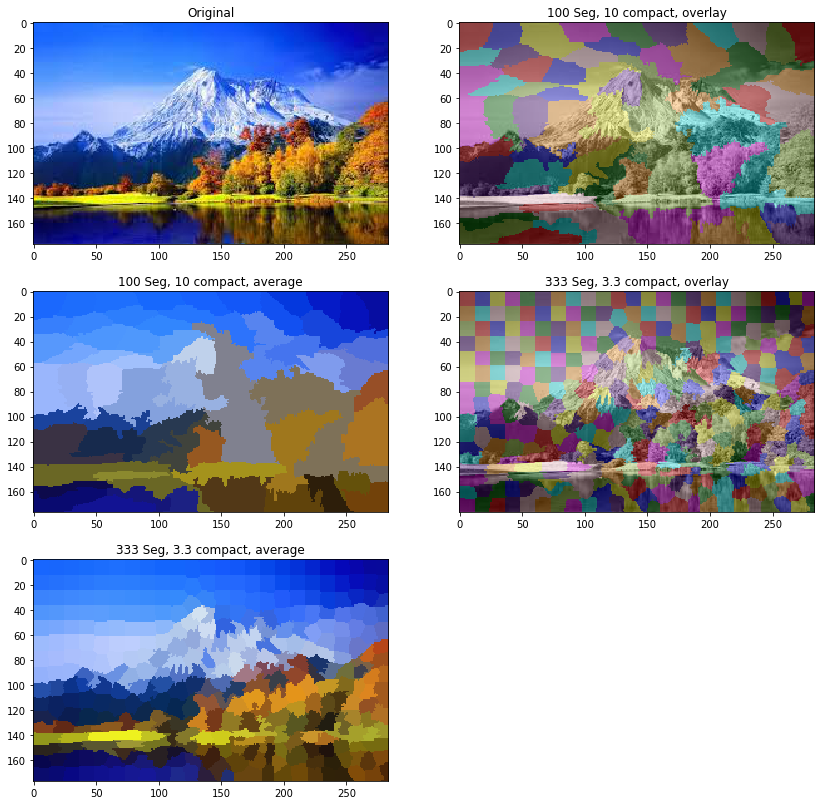

In [2]:
img = io.imread('vibrant.jpeg')

label1 = segmentation.slic(img) #default 100 segments, 10.0 overlay
label2 = segmentation.slic(img,n_segments=333,compactness=33) 
#higher compactness gives more shape to segment in the form of a square as it describes spatial closeness

overlay1_1 = color.label2rgb(label1,img,kind='overlay') # overlay the segments over image
overlay1_2 = color.label2rgb(label1,img,kind='avg') # depict average color value of that segment
overlay2_1 = color.label2rgb(label2,img,kind='overlay')
overlay2_2 = color.label2rgb(label2,img,kind='avg')

f,ax = plt.subplots(3,2,figsize=(14,14))
ax = ax.ravel()

ax[0].imshow(img)
ax[0].set_title('Original')

ax[1].imshow(overlay1_1)
ax[1].set_title('100 Seg, 10 compact, overlay')

ax[2].imshow(overlay1_2)
ax[2].set_title('100 Seg, 10 compact, average')

ax[3].imshow(overlay2_1)
ax[3].set_title('333 Seg, 3.3 compact, overlay')

ax[4].imshow(overlay2_2)
ax[4].set_title('333 Seg, 3.3 compact, average')

f.delaxes(ax[-1])
plt.show()

## Create RAG

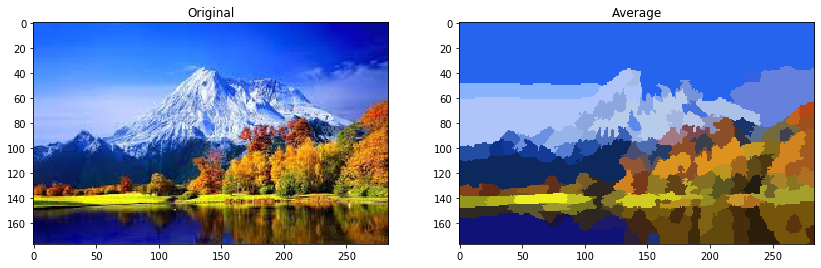

In [3]:
# 333 segments will be our favourite now as it seems to extract better segments
rag = future.graph.rag_mean_color(img,label2,connectivity=3,mode='distance',sigma=321)
new_labels = future.graph.cut_threshold(label2,rag,thresh=27) 
# merge each and every two labels who have distance less than the thresh

rag_img_avg = color.label2rgb(new_labels,img,kind='avg')

f,ax = plt.subplots(1,2,figsize=(14,5))
ax = ax.ravel()

ax[0].imshow(img)
ax[0].set_title('Original')

ax[1].imshow(rag_img_avg)
ax[1].set_title('Average')
plt.show()

# Object Detection
There are many ways to do the same using one technique or a blend of multiple techniques. We'll be discussing a few of those techniques.

**Some of the techniques are image specific like `gaussian/bilateral filter to remove noise`, `opening/closing to remove small spots` or `dilation/erosion to fill the holes and patches` and you may or may not need them with your image**.

Very detailed discussions about the thresholding, Canny, filters, histogram is given in my previous notebooks of this Image Processing series.

**Steps are given as the comments to the code**
## Threshold + Local Maxima + Canny

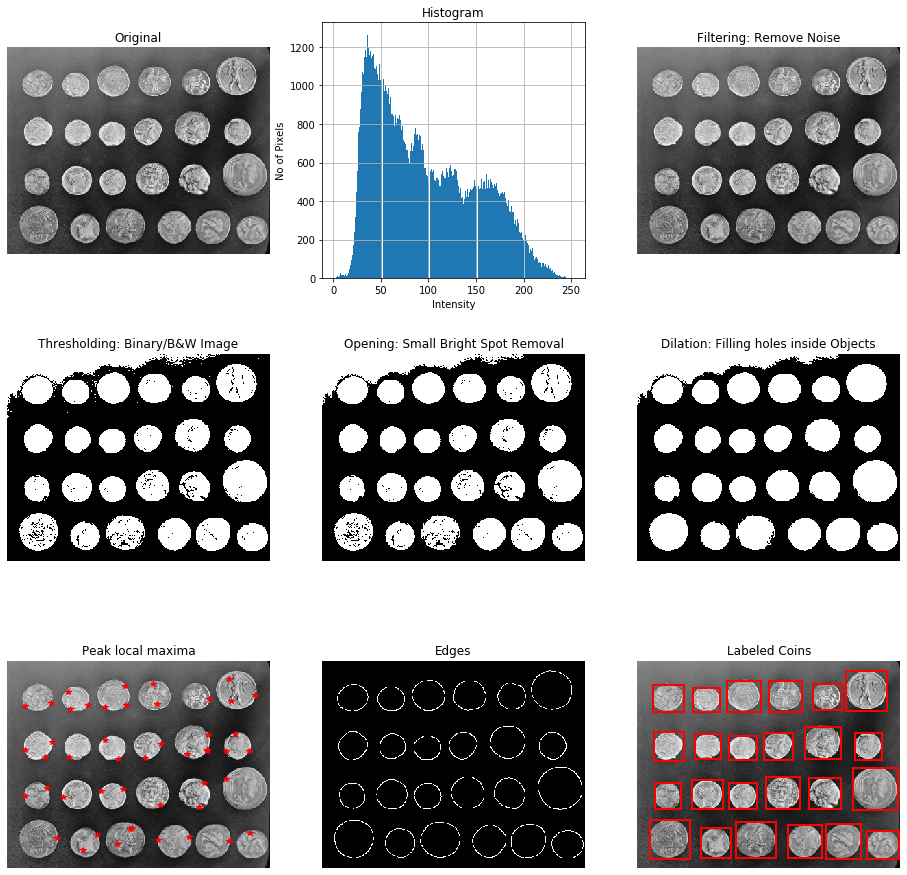

In [86]:
# Import Image and Convert to Grayscale
image = data.coins()
image = color.rgb2gray(image)

# make a figure to plot our steps
fig, axes = plt.subplots(ncols=3, nrows=3,figsize=(16,16))
ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes.flat

# plot original image
ax0.imshow(image, cmap='gray')
ax0.set_title('Original',)
ax0.axis('off')

# plot an Histogram of image
ax1.hist(image.flatten(),bins=256, lw=2,)
ax1.set_xlabel('Intensity')
ax1.set_ylabel('No of Pixels')
ax1.set_title('Histogram')
ax1.grid()

# Denoise Image using one or both or combination based on level of noise **we have no noise
# image = restoration.denoise_bilateral(image) # bilateral
# image = filters.gaussian(image,0.01) # gaussian
ax2.imshow(image, cmap='gray')
ax2.set_title('Filtering: Remove Noise')
ax2.axis('off')

# apply any threshold local,median,otsu etc
thresh = filters.threshold_otsu(image) # Otsu Threshold
bw = image.copy() > thresh # get Binary Image
# bw = filters.threshold_local(image, 95, offset=-15) # Local threshold to get binary image

ax3.imshow(bw, cmap='gray')
ax3.set_title('Thresholding: Binary/B&W Image')
ax3.axis('off')

# Perform Opening which removes any bright spots less than the threshold size in a B&W Image
bw = morphology.area_opening(bw,area_threshold=50)
ax4.imshow(bw, cmap='gray')
ax4.set_title('Opening: Small Bright Spot Removal')
ax4.axis('off')

# Dilation to remove the blemishes in the coins
inverted = util.invert(bw) # black coins white background
dilation_seed = inverted.copy() 
dilation_seed[1:-1,1:-1] = inverted.min()
mask = inverted
dilated_img = morphology.reconstruction(dilation_seed,mask,method='dilation')
bw = util.invert(dilated_img) # convert to original White Coins and Black Background

ax5.imshow(bw, cmap='gray')
ax5.set_title('Dilation: Filling holes inside Objects',)
ax5.axis('off')

# Apply Local Maxima to find the Peak  Gradient intensities of the local objects
coordinates = feature.peak_local_max(image, min_distance=20)

ax6.imshow(image, cmap=plt.cm.gray)
ax6.autoscale(False)
ax6.plot(coordinates[:, 1],coordinates[:, 0], c='r',ls='none',marker='*')
ax6.set_title('Peak local maxima',)
ax6.axis('off')

# Find Edges from using Canny Filter
edges = feature.canny(image, sigma=3,low_threshold=10,high_threshold=80)

ax7.imshow(edges, cmap='gray')
ax7.set_title('Edges',)
ax7.axis('off')

#  Give label to each object in the image and draw a rectangle over that label
label_image = morphology.label(edges)

ax8.imshow(image, cmap=plt.cm.gray)
ax8.set_title('Labeled Coins')
ax8.axis('off')
 # Draw rectangle around segmented coins.
for region in measure.regionprops(label_image):
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red',lw=2)
    ax8.add_patch(rect)
    
plt.show()